In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import nibabel as nib
import pycip.chart as C
from pycip.math_utils import two_sample_t_test
import os
from copy import deepcopy
from sklearn.linear_model import LinearRegression
from scipy.stats import wilcoxon
from sklearn.metrics import r2_score
from scipy import stats
from scipy.optimize import minimize, Bounds, LinearConstraint, NonlinearConstraint
from scipy.spatial import distance_matrix
from scipy.stats import ttest_rel
import pycip

%load_ext autoreload
%autoreload 2

C.Chart.legend_fontsize = 10
C.ChartGroup.chart_cls = C.Chart

In [2]:
sgfreqmapping = np.fromfile('E:/dingjie/mipresearch/data/cochlear/sgfreqmapping.bin', dtype=np.uint8)
sgfreqmapping = sgfreqmapping[: 17947 - 1]
active_mod_index = np.where(sgfreqmapping > 0)[0]

In [3]:
def load_res(cases, structures, method_name):
    mask = {}
    verts = {}

    for case in cases:
        mask[case] = {}
        verts[case] = {}
        for s in structures:
            s_mask = nib.load(f'output/mask/{method_name}/{s}/{case}.nii.gz').get_fdata().astype(np.uint8)
            s_verts, tris = pycip.utils.read_mesh(f'output/mesh/{method_name}/{s}/{case}.mesh')
            mask[case][s] = s_mask
            if s  == 'MD':
                s_verts = s_verts[active_mod_index, :]
            verts[case][s] = s_verts
    return mask, verts

def load_res_md_upsample(cases, structures, method_name, tag):
    mask = {}
    verts = {}

    for case in cases:
        mask[case] = {}
        verts[case] = {}
        for s in structures:
            s_mask = nib.load(f'output/mask/{method_name}/{s}/{case}.nii.gz').get_fdata().astype(np.uint8)
            if s == 'MD':
                s_verts, tris = pycip.utils.read_mesh(f'output/mesh/{method_name}/MD_upsample{tag}/{case}.mesh')
            else:
                s_verts, tris = pycip.utils.read_mesh(f'output/mesh/{method_name}/{s}/{case}.mesh')
            mask[case][s] = s_mask
            if s  == 'MD':
                s_verts = s_verts[active_mod_index, :]
            verts[case][s] = s_verts
    return mask, verts

In [4]:
test_cases = [item.replace('.nii.gz', '') for item in os.listdir('output/mask/chamfer/CC')]
structures = ['MD', 'ST', 'SV', 'CC']

In [5]:
gt_res = load_res(test_cases, structures, 'gt')
chamfer_res = load_res(test_cases, structures, 'chamfer')
p2p_res = load_res(test_cases, structures, 'p2p')
cgan_res = load_res(test_cases, structures, 'cgan')
aba_res = load_res(test_cases, structures, 'aba')
# nnunet_res = load_res(test_cases, structures, 'nnunet')
# segnet_res = load_res(test_cases, structures, 'segnet')
nnunet_res_md_upsample1 = load_res_md_upsample(test_cases, structures, 'nnunet', tag=1)
# nnunet_res_md_upsample2 = load_res_md_upsample(test_cases, structures, 'nnunet', tag=2)
segnet_res_md_upsample1 = load_res_md_upsample(test_cases, structures, 'segnet', tag=1)
# segnet_res_md_upsample2 = load_res_md_upsample(test_cases, structures, 'segnet', tag=2)
elastix_res = load_res(test_cases, structures, 'elastix')

In [5]:
load_res(test_cases, structures, 'nnunet')

({'PID_1689_PLANID_1096_LEFT': {'MD': array([[[0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0],
           ...,
           [0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0]],
   
          [[0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0],
           ...,
           [0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0]],
   
          [[0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0],
           ...,
           [0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0]],
   
          ...,
   
          [[0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0],
           ...,
           [0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0]],
  

In [6]:
def method_dice(cases, structures, method_res, gt_res):
    method_res = method_res[0]
    gt_res = gt_res[0]
    res = {}
    for s in structures:
        res[s] = []
        for case in cases:
            mask_pred = method_res[case][s]
            gt = gt_res[case][s]
            dice = 2 * (mask_pred * gt).sum() / ((mask_pred + gt).sum() + 10e-6)
            res[s].append(dice)
    return res

def method_p2p(cases, structures, method_res, gt_res):
    method_res = method_res[1]
    gt_res = gt_res[1]
    res = {}
    for s in structures:
        res[s] = []
        for case in cases:
            mask_pred = method_res[case][s]
            gt = gt_res[case][s]
            p2p = np.sqrt(((mask_pred - gt) ** 2).sum(axis=1)) * 0.2
            res[s].append(np.median(p2p))
    return res

def method_auc(method):
    return {}


In [7]:
chamfer_res_dice = method_dice(test_cases, structures, chamfer_res, gt_res)
p2p_res_dice = method_dice(test_cases, structures, p2p_res, gt_res)
cgan_res_dice = method_dice(test_cases, structures, cgan_res, gt_res)
nnunet_res_dice = method_dice(test_cases, structures, nnunet_res_md_upsample1, gt_res)
segnet_res_dice = method_dice(test_cases, structures, segnet_res_md_upsample1, gt_res)
aba_res_dice = method_dice(test_cases, structures, aba_res, gt_res)
elastix_res_dice = method_dice(test_cases, structures, elastix_res, gt_res)

chamfer(MD) v.s cGAN+ASM(MD):  0.000320998603983214 ***
chamfer(MD) v.s nnU-Net(MD):  7.019631244464945e-08 ***
chamfer(MD) v.s SegNet(MD):  0.10380097093895765 ns
chamfer(MD) v.s ABA(MD):  1.1920864122849158e-16 ***
chamfer(MD) v.s Elastix(MD):  1.1920864122849158e-16 ***
chamfer(ST) v.s cGAN+ASM(ST):  0.9778971635173507 ns
chamfer(ST) v.s nnU-Net(ST):  6.789971025970408e-13 ***
chamfer(ST) v.s SegNet(ST):  0.5633625160778162 ns
chamfer(ST) v.s ABA(ST):  1.2323821380201547e-16 ***
chamfer(ST) v.s Elastix(ST):  1.2323821380201547e-16 ***
chamfer(SV) v.s cGAN+ASM(SV):  0.45922208400453535 ns
chamfer(SV) v.s nnU-Net(SV):  1.4171121392733776e-11 ***
chamfer(SV) v.s SegNet(SV):  0.23979551421166267 ns
chamfer(SV) v.s ABA(SV):  1.2740202782472502e-16 ***
chamfer(SV) v.s Elastix(SV):  1.1920864122849158e-16 ***
chamfer(Labyrinth) v.s nnU-Net(Labyrinth):  6.140266698981107e-15 ***
chamfer(Labyrinth) v.s SegNet(Labyrinth):  2.909168619122272e-16 ***
chamfer(Labyrinth) v.s ABA(Labyrinth):  1.19

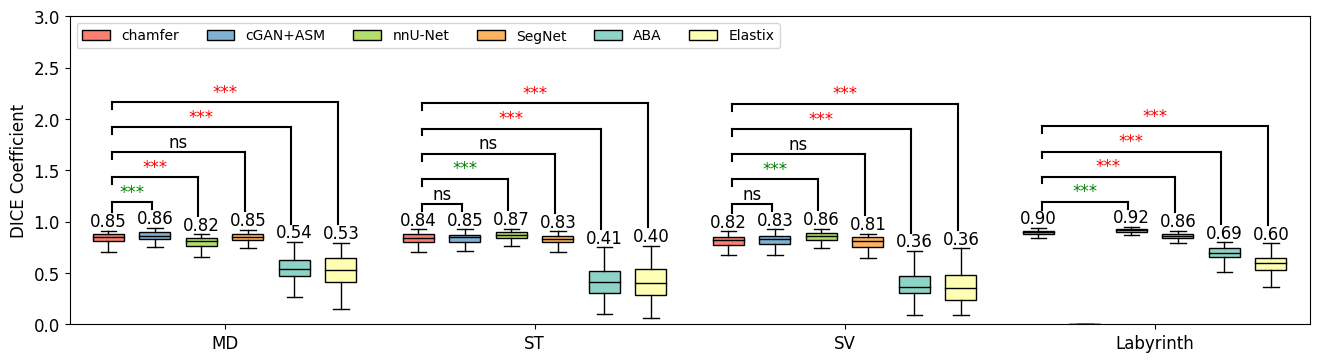

In [8]:
box_data = [
    [chamfer_res_dice[s] for s in structures],
    # [p2p_res_dice[s] for s in structures],
    [cgan_res_dice[s] if s !='CC' else np.zeros(91) for s in structures],
    [nnunet_res_dice[s] for s in structures],
    # [np.array(segnet_res_dice[s]) - np.random.random(91) * 0.1 for s in structures],
    [segnet_res_dice[s] for s in structures],
    [aba_res_dice[s] for s in structures],
    [elastix_res_dice[s] for s in structures],
]

chart = C.Chart()
chart.legend_ncol = 6
chart.legend_loc = 'upper left'
sig_pairs = []
for i in range(4):
    for j in range(1, 6):
        # if i == 0 and j in (3, 4, 5): continue
        if i == 3 and j == 1:
            continue
        sig_pairs.append([[i, 0], [i, j]])
chart.set_figsize(16, 4)
chart.ylabel('DICE Coefficient')
chart.boxplot(box_data, bar_labels=['MD', 'ST', 'SV', 'Labyrinth'], 
              series_labels=['chamfer', 'cGAN+ASM', 'nnU-Net', 'SegNet', 'ABA', 'Elastix'], significance_pairs=sig_pairs,
              significance_bar_top_offset=0.15,
              significance_bar_verticle_line_length_ratio=0.1,
              significance_text_y_offest=0.05,
              significance_test_use_color=['red', 'green'],
              auto_figsize=False
            #   significance_test_method='t-test'
              )
chart.yticks(0, 3)

chamfer(MD) v.s cGAN+ASM(MD):  0.7069161065795584 ns
chamfer(MD) v.s nnU-Net(MD):  1.1920864122849158e-16 ***
chamfer(MD) v.s SegNet(MD):  1.1920864122849158e-16 ***
chamfer(MD) v.s ABA(MD):  1.1920864122849158e-16 ***
chamfer(MD) v.s Elastix(MD):  1.1920864122849158e-16 ***
chamfer(ST) v.s cGAN+ASM(ST):  0.0544119826842194 ns
chamfer(ST) v.s nnU-Net(ST):  5.551296981743469e-12 ***
chamfer(ST) v.s SegNet(ST):  4.4835719137818166e-15 ***
chamfer(ST) v.s ABA(ST):  1.1920864122849158e-16 ***
chamfer(ST) v.s Elastix(ST):  1.2323821380201547e-16 ***
chamfer(SV) v.s cGAN+ASM(SV):  0.004714138363693506 **
chamfer(SV) v.s nnU-Net(SV):  7.251270041036038e-16 ***
chamfer(SV) v.s SegNet(SV):  3.427552705034359e-16 ***
chamfer(SV) v.s ABA(SV):  1.2323821380201547e-16 ***
chamfer(SV) v.s Elastix(SV):  1.2740202782472502e-16 ***
chamfer(Labyrinth) v.s nnU-Net(Labyrinth):  3.690128917438134e-14 ***
chamfer(Labyrinth) v.s SegNet(Labyrinth):  1.4548995404017362e-16 ***
chamfer(Labyrinth) v.s ABA(Labyri

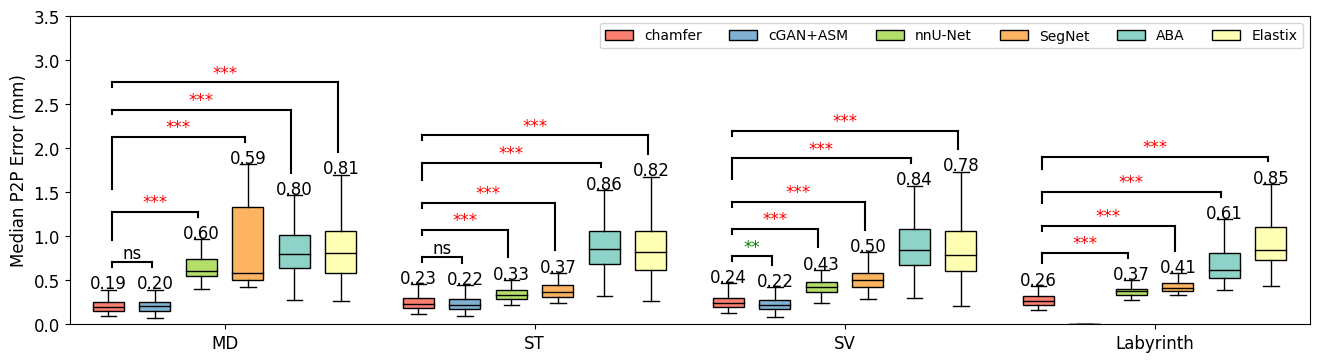

In [9]:
chamfer_res_p2p = method_p2p(test_cases, structures, chamfer_res, gt_res)
p2p_res_p2p = method_p2p(test_cases, structures, p2p_res, gt_res)
cgan_res_p2p = method_p2p(test_cases, structures, cgan_res, gt_res)
nnunet_res_p2p = method_p2p(test_cases, structures, nnunet_res_md_upsample1, gt_res)
segnet_res_p2p = method_p2p(test_cases, structures, segnet_res_md_upsample1, gt_res)
aba_res_p2p = method_p2p(test_cases, structures, aba_res, gt_res)
elastix_res_p2p = method_p2p(test_cases, structures, elastix_res, gt_res)

box_data = [
    [chamfer_res_p2p[s] for s in structures],
    # [p2p_res_p2p[s] for s in structures],
    [cgan_res_p2p[s] if s !='CC' else np.zeros(91) for s in structures],
    [nnunet_res_p2p[s] for s in structures],
    [segnet_res_p2p[s] for s in structures],
    [aba_res_p2p[s] for s in structures],
    [elastix_res_p2p[s] for s in structures]
]

sig_pairs = []
for i in range(4):
    for j in range(1, 6):
        # if i == 0 and j in (3, 4, 5): continue
        if i == 3 and j == 1:
            continue
        sig_pairs.append([[i, 0], [i, j]])

chart = C.Chart()
chart.set_figsize(16, 4)
chart.ylabel('Median P2P Error (mm)')
chart.legend_ncol = 6
chart.legend_loc = 'upper right'
chart.boxplot(box_data, bar_labels=['MD', 'ST', 'SV', 'Labyrinth'], 
              series_labels=['chamfer', 'cGAN+ASM', 'nnU-Net', 'SegNet', 'ABA', 'Elastix'],
              significance_test_use_color=['green', 'red'],
              significance_pairs=sig_pairs, 
              significance_bar_top_offset=0.2,
              significance_bar_verticle_line_length_ratio=0.06,
              significance_text_y_offest=0.05,
              auto_figsize=False
              )
chart.yticks(0, 3.5)

In [20]:
nnunet_md_p2p = dict(zip(test_cases, nnunet_res_p2p['MD']))
nnunet_md_p2p_sorted = sorted(nnunet_md_p2p.items(), key=lambda x: x[1])
best, avg, worst = nnunet_md_p2p_sorted[0][0], nnunet_md_p2p_sorted[46][0], nnunet_md_p2p_sorted[-1][0]
best, avg, worst

('PID_2674_PLANID_1312_LEFT',
 'PID_2182_PLANID_878_RIGHT',
 'PID_2552_PLANID_732_LEFT')

## Correspondence Error

In [10]:
exp_root = 'E:/dingjie/mipresearch/reg_cochlear_monai/s8'

In [11]:
error_excels = [
    # f'{exp_root}/cGAN_ASM_error.csv',
    f'{exp_root}/exp_best_model/Exp_task06-kcl-p2p-reg4p0-post_1/evaluation/epoch_best_postONpost_best_minmax.csv',
    f'{exp_root}/exp_best_model/Exp_task16-kcl-chamfer-reg4p0-post_1/evaluation/epoch_best_postONpost_best_minmax.csv',
    f'{exp_root}/exp_best_model/Exp_task51-kcl-chamfer0-dice-mse0-cc0-reg4p0-post_1/evaluation/epoch_best_postONpost_best.csv',
    f'{exp_root}/exp_best_model/Exp_task21-kcl-dice-cc-reg4p0-post_1/evaluation/epoch_best_postONpost_best_minmax.csv',
    f'{exp_root}/exp_best_model/Exp_task20-kcl-dice-mse-reg4p0-post_1/evaluation/epoch_best_postONpost_best_minmax.csv',
    f'{exp_root}/exp_best_model/Exp_task51-kcl-chamfer-dice-mse1-cc0-reg4p0-post_1/evaluation/epoch_best_postONpost_best.csv',
    f'{exp_root}/exp_best_model/Exp_task19-kcl-crosscorr-reg4p0-post_1/evaluation/epoch_best_postONpost_best_minmax.csv',
    f'{exp_root}/exp_best_model/Exp_task18-kcl-mse-reg4p0-post_1/evaluation/epoch_best_postONpost_best_minmax.csv',
    # 'E:/dingjie/mipresearch/data/cochlear/data_128_inAtlas_99clip/test93_aba_error.csv',
    f'{exp_root}/no_registration_error.csv'
]

# error_labels = ['cGAN+ASM', 'p2p', 'chamfer', 'dice','dice+cross-correlation', 'dice+mse', 
#           'chamfer+dice+mse', 'cross-correlation', 'mse', 'ABA', 'no deformation']

error_labels = ['p2p', 'chamfer', 'dice','dice+cross-correlation', 'dice+mse', 
          'chamfer+dice+mse', 'cross-correlation', 'mse', 'no deformation']

keys = ['ac_median', 'st_median', 'sv_median', 'cc_median']

title = ''
ylims = [0, 3.5]

error_dfs = [pd.read_csv(item) for item in error_excels]

p2p(MD) v.s chamfer(MD):  0.0036288799615056444 **
p2p(ST) v.s chamfer(ST):  0.1518710418099196 ns
p2p(SV) v.s chamfer(SV):  0.030387204404959768 *
p2p(Labyrinth) v.s chamfer(Labyrinth):  2.4868941782984058e-11 ***


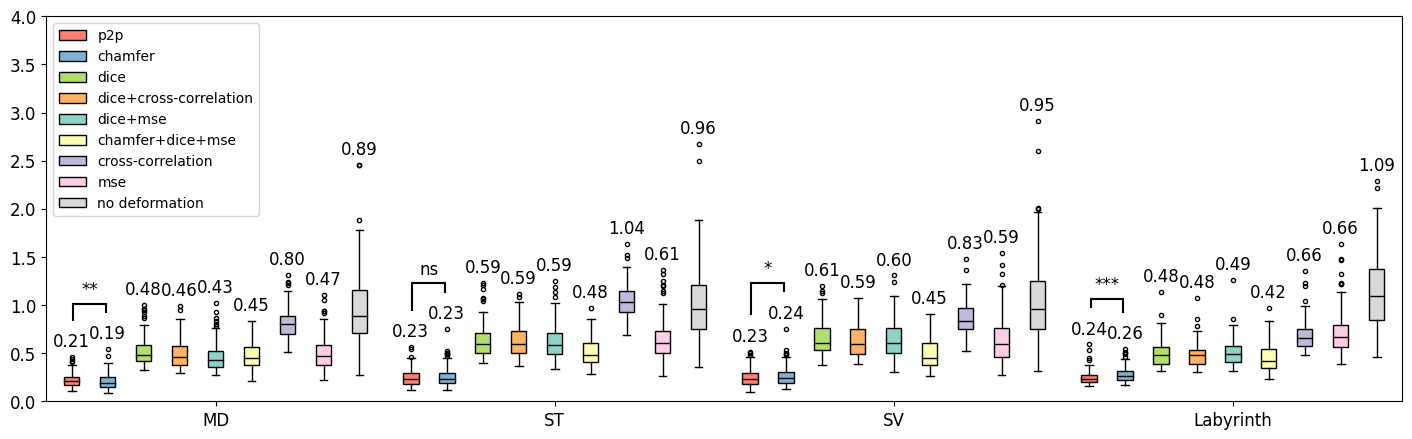

In [12]:
box_data = [[df[key].tolist() for key in keys] for df in error_dfs]

chart = C.Chart()
chart.legend_ncol = 1
chart.legend_loc = 'upper left'
chart.set_figsize(17.5, 5)
sig_pairs = [[[0, 0], [0, 1]], [[1, 0], [1, 1]], [[2, 0], [2, 1]], [[3, 0], [3, 1]]]
chart.boxplot(box_data, bar_labels=['MD', 'ST', 'SV', 'Labyrinth'], series_labels=error_labels, 
              showfliers=True, stats_label_y_offset=0.5, 
              significance_pairs=sig_pairs, 
              significance_bar_top_offset=0.3,
              significance_bar_verticle_line_length_ratio=0.06,
              significance_text_y_offest=0.1,
              barwidth=0.3,
              space_between_bars=0.4,
              auto_figsize=False
              )
chart.yticks(ticks=np.linspace(0, 4, 9))

## AUC

In [13]:
auc_excels = [
    # f'{exp_root}/cGAN_ASM_error_auc.csv',
    f'{exp_root}/exp_best_model/Exp_task06-kcl-p2p-reg4p0-post_1/evaluation/epoch_best_postONpost_best_auc.csv',
    f'{exp_root}/exp_best_model/Exp_task16-kcl-chamfer-reg4p0-post_1/evaluation/epoch_best_postONpost_best_auc.csv',
    f'{exp_root}/exp_best_model/Exp_task51-kcl-chamfer0-dice-mse0-cc0-reg4p0-post_1/evaluation/epoch_best_postONpost_best_auc.csv',
    f'{exp_root}/exp_best_model/Exp_task21-kcl-dice-cc-reg4p0-post_1/evaluation/epoch_best_postONpost_best_auc.csv',
    f'{exp_root}/exp_best_model/Exp_task20-kcl-dice-mse-reg4p0-post_1/evaluation/epoch_best_postONpost_best_auc.csv',
    f'{exp_root}/exp_best_model/Exp_task51-kcl-chamfer-dice-mse1-cc0-reg4p0-post_1/evaluation/epoch_best_postONpost_best_auc.csv',
    f'{exp_root}/exp_best_model/Exp_task19-kcl-crosscorr-reg4p0-post_1/evaluation/epoch_best_postONpost_best_auc.csv',
    f'{exp_root}/exp_best_model/Exp_task18-kcl-mse-reg4p0-post_1/evaluation/epoch_best_postONpost_best_auc.csv',
    # 'E:/dingjie/mipresearch/data/cochlear/data_128_inAtlas_99clip/test93_aba_error_auc.csv',
    f'{exp_root}/no_registration_auc.csv'
]

# auc_labels = ['cGAN+ASM', 'p2p', 'chamfer', 'dice','dice+cross-correlation', 'dice+mse', 
#           'chamfer+dice+mse', 'cross-correlation', 'mse', 'ABA', 'no deformation']

auc_labels = ['p2p', 'chamfer', 'dice','dice+cross-correlation', 'dice+mse', 
          'chamfer+dice+mse', 'cross-correlation', 'mse', 'no deformation']

auc_dfs = [pd.read_csv(item) for item in auc_excels]

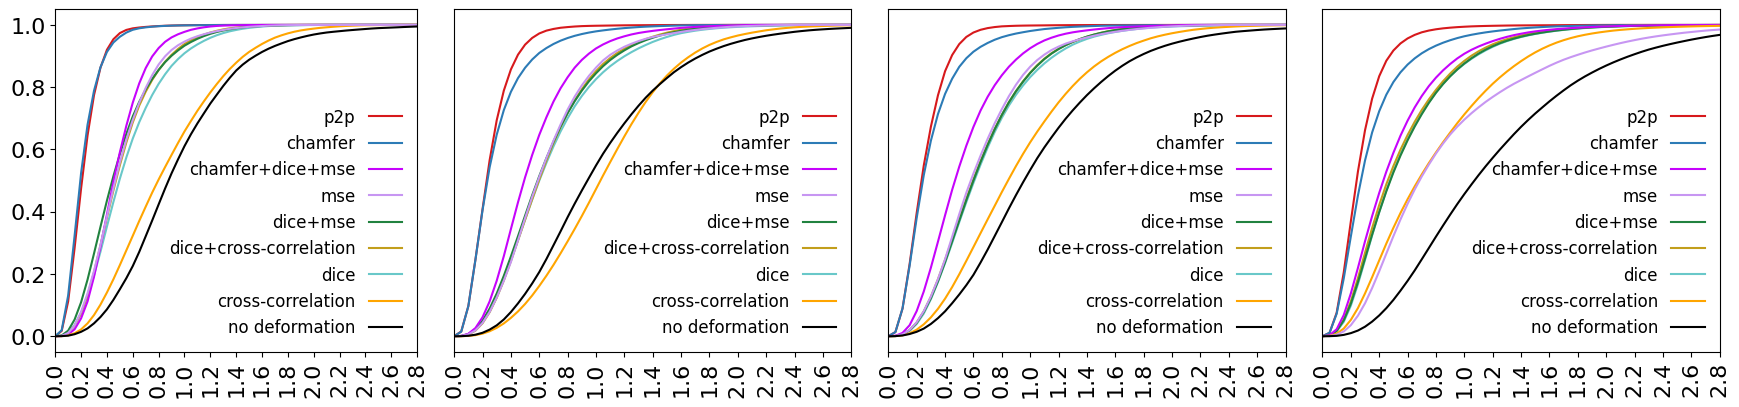

In [14]:


colors = ['#D7191C', '#2C7BB6', '#69c8c9', '#c29e1b', '#21823f', '#c603fc', 'orange', '#c796f2','black', '#fb8072', 'black']

cg = C.ChartGroup(1, 4, width_ratios=[1.2,  1.2, 1.2, 1.2], height_ratios=[1.1])

for i, key in enumerate(['ac_auc', 'st_auc', 'sv_auc', 'cc_auc']):

    chart = cg.get_chart(1, i + 1)
    chart.config(16, 16)
    chart.legend_fontsize = 14

    title = ''
    ylims = [0, 3]

    x = [i * 0.05 for i in range(60)]

    lines = []
    for df in auc_dfs:
        data = []
        if key not in df.keys():
            lines.append(None)
            continue
        for i, row in df.iterrows():
            cur_data = [float(x) for x in row[key].split('#')]
            data.append(cur_data)
        data = np.array(data)
        line = data.mean(axis=0)
        lines.append(line)

    for j, line in enumerate(lines):
        if line is None:
            continue
        # chart.line(x, line, color(j), label=auc_labels[j])
        chart.line(x, line, colors[j], label=auc_labels[j])

    chart.xticks(0, 2.8, 15, rotation=90)

    if key != 'ac_auc':
        chart.yaxis_off()

    # cg.fig.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], [0, 0.2, 0.4, 0.6, 0.8, 1.0])

    handles, lbs = plt.gca().get_legend_handles_labels()

    order = [0, 1, 5, 7, 4, 3, 2, 6, 8]
    chart.legend_fontsize=12
    chart.legend_loc='lower right'
    # chart.show_legend(frameon=False)
    handles, labels = chart.ax.get_legend_handles_labels()
    legend = chart.show_legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False, markerfirst=False)

    # legend = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="lower right", fontsize=16, markerfirst=False)
    # legend.get_frame().set_alpha(None)
    # legend.get_frame().set_facecolor((1, 1, 1, 0))
    # legend.get_frame().set_linewidth(0.0)
    # plt.show()

## Visualize

In [15]:
def plot_cochlear(case, z_index, colors, cg, structure_order):
    img = nib.load(f'E:/dingjie/mipresearch/data/cochlear/data_128_inAtlas_99clip/test93/Post_img/{case}.nii.gz')
    affine, img_data = img.affine, img.get_fdata().astype(np.float32)
    voxsz = np.abs([affine[0, 0], affine[1, 1], affine[2, 2]])

    chamfers = []
    p2ps = []
    cgans = []
    nnunets = []
    segnets = []
    abas = []
    gts = []

    for i, s in enumerate(structure_order):
        gt = nib.load(f'E:/dingjie/mipresearch/data/cochlear/data_128_inAtlas_99clip/test93/{s}_mask/{case}.nii.gz').get_fdata().astype(np.float32)
        chamfer = nib.load(f'output/mask/chamfer/{s}/{case}.nii.gz').get_fdata().astype(np.float32)
        p2p = nib.load(f'output/mask/p2p/{s}/{case}.nii.gz').get_fdata().astype(np.float32)
        cgan = nib.load(f'output/mask/cgan/{s}/{case}.nii.gz').get_fdata().astype(np.float32)
        nnunet = nib.load(f'output/mask/nnunet/{s}/{case}.nii.gz').get_fdata().astype(np.float32)
        segnet = nib.load(f'output/mask/segnet/{s}/{case}.nii.gz').get_fdata().astype(np.float32)
        aba = nib.load(f'output/mask/aba/{s}/{case}.nii.gz').get_fdata().astype(np.float32)

        print(s, 2 * ((aba * gt)).sum() / (aba.sum() + gt.sum() + 1e-5))

        chamfers.append(chamfer)
        p2ps.append(p2p)
        cgans.append(cgan)
        nnunets.append(nnunet)
        segnets.append(segnet)
        abas.append(aba)
        gts.append(gt)

    for i, item in enumerate([gts, chamfers, p2ps, cgans, nnunets, segnets, abas]):
        chart = cg.get_chart(1, i + 1)
        # chart.slice(img_data, orientation='y', voxsz=[1, 1, 1], mask_overlays=[[mask, color] for mask, color in zip(item, colors)])
        chart.axis_off()
        chart.slice(np.flip(img_data, 1)[20: 108, 20: 108, 20: 108], orientation='z', slice_index=z_index, voxsz=[1, 1, 1], mask_overlays=[[np.flip(mask, 1)[20: 108, 20: 108, 20: 108], color] for mask, color in zip(item, colors)])

    chart6 = cg.get_chart(1, 6)
        # chart.slice(img_data, orientation='y', voxsz=[1, 1, 1], mask_overlays=[[mask, color] for mask, color in zip(item, colors)])
    chart6.axis_off()
    chart6.slice(np.flip(img_data, 1)[20: 108, 20: 108, 20: 108], orientation='z', slice_index=z_index, voxsz=[1, 1, 1])

CC 0.790527848548885
ST 0.5508132293954664
SV 0.5212303067948533
MD 0.6691086679415513


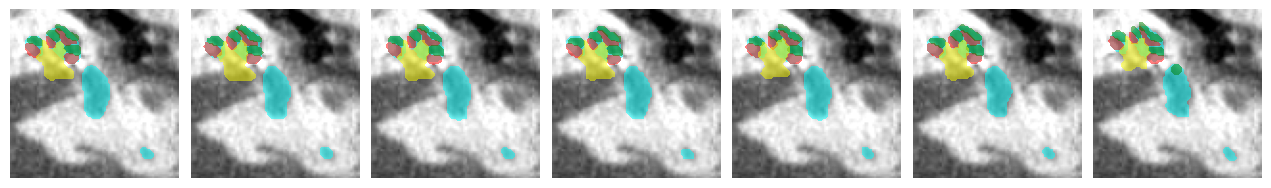

In [16]:
cg = C.ChartGroup(1, 7, each_width=2, each_height=2)

colors = ['cyan', 'red', 'green', 'yellow']
structure_order = ['CC', 'ST', 'SV', 'MD']

plot_cochlear('PID_3289_PLANID_3664_RIGHT', z_index=30, colors=colors, structure_order=structure_order, cg=cg)

CC 0.6794552940271017
ST 0.28468368453136916
SV 0.2505327962934729
MD 0.5952112667673081


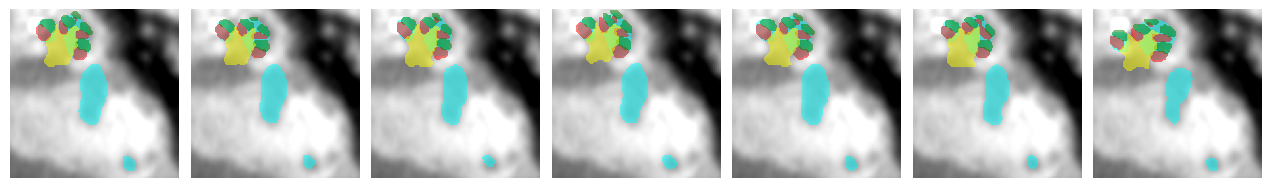

In [17]:
cg = C.ChartGroup(1, 7, each_width=2, each_height=2)

colors = ['cyan', 'red', 'green', 'yellow']
structure_order = ['CC', 'ST', 'SV', 'MD']

plot_cochlear('PID_2674_PLANID_932_RIGHT', z_index=30, colors=colors, structure_order=structure_order, cg=cg)

## DVFs

In [9]:
def read_freqmap(modfreqfile):
    # Open the file in binary read mode
    with open(modfreqfile, "rb") as fid2:
        # Allocate memory for modmsk as a list of integers
        modiolus_numverts = 17947

        act = np.fromfile(fid2, dtype=np.int32, count=modiolus_numverts)
        freq = np.fromfile(fid2, dtype=np.float32, count=modiolus_numverts)
        ang = np.fromfile(fid2, dtype=np.float32, count=modiolus_numverts)

    return {'act': act, 'freq': freq, 'ang': ang}

def get_dvf(electrode_config, modiolus_verts, freqmap, bins):
    dist_map = distance_matrix(electrode_config['electrodepos'], modiolus_verts)
    dvf_vert_inds = []
    for i in range(len(bins) - 1):
        if i == 15:
            print(bins[i], bins[i + 1])
        verts_ind = np.where((freqmap['act'] == 1) & (freqmap['freq'] >= bins[i]) & ((freqmap['freq'] < bins[i + 1])))[0]
        dvf_vert_inds.append(verts_ind)

    dvfs = []
    for i in range(len(electrode_config['electrodepos'])):
        dvf_cur_contact = []
        for j in range(len(bins) - 1):
            if len(dvf_vert_inds[j]) == 0:
                dvf_cur_contact.append(0)
                continue
            v = dist_map[i, dvf_vert_inds[j]]
            dvf_cur_contact.append(v.min() * 0.2)
        dvfs.append(np.array(dvf_cur_contact))

    # find vally
    smoothed_dvfs = []
    vally = []
    for i, item in enumerate(dvfs):

        contact_angle = electrode_config['electrodeangs'][i]
        contact_freq = freqmap['freq'][np.argmin(np.abs(freqmap['ang'] - contact_angle))]
        contact_freq_log = np.log(contact_freq)
        t_log = 0.5
        x = np.log(bins[: -1])
        cut_ind = np.where((x > contact_freq_log - t_log) & (x < contact_freq_log + t_log))[0]

        box = np.ones(5) / 5
        item = np.concatenate([np.ones(2) * item[0], item, np.ones(2) * item[-1]])
        y_smooth = np.convolve(item, box, mode='valid')
        smoothed_dvfs.append(y_smooth)
        cut_min_ind = y_smooth[cut_ind].argmin()
        cut_min = y_smooth[cut_ind].min()
        vally.append([cut_ind[cut_min_ind], bins[cut_ind][cut_min_ind], cut_min])
    
    return dvfs, smoothed_dvfs, vally

## nnunet

203.566162109375 214.06906127929688
203.566162109375 214.06906127929688


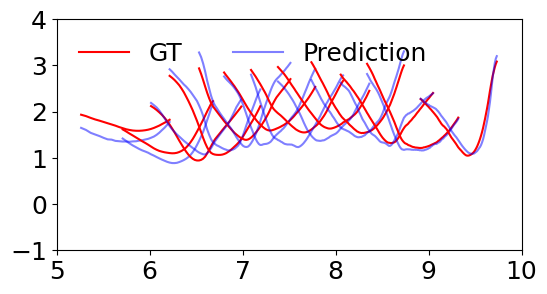

In [ ]:
freqmap = read_freqmap('E:/dingjie/mipresearch/data/cochlear/sgfreqmapping.bin')

exp_root = 'E:/dingjie/mipresearch/reg_cochlear_monai/s8/exp_best_model'
exp = 'Exp_task16-kcl-chamfer-reg4p0-post_1'


case = 'PID_1689_PLANID_1096_LEFT'
case2 = 'PID_2674_PLANID_1312_LEFT'
case3 = 'PID_2182_PLANID_878_RIGHT'
case4 = 'PID_2552_PLANID_732_LEFT'

case = case2
# case = 'PID_3548_PLANID_4361_LEFT'

infor_name = case.replace('_LEFT', '').replace('_RIGHT', '')
infor = pycip.utils.loadmat(f'E:/dingjie/mipresearch/data/cochlear/prepos_mesh_all_DONOTDELETE_new/{infor_name}.mat')['cdb_infor']

md_tri = infor['pre_MD']['triangles'].T

gt_md = np.load(f'E:/dingjie/mipresearch/data/cochlear/data_128_inAtlas_99clip/test93/PrePost_FullMD_vtx/{case}.pkl', allow_pickle=True)
contacts = np.load(f'E:/dingjie/mipresearch/data/cochlear/data_128_inAtlas_99clip/test93/PrePost_contacts/{case}.pkl', allow_pickle=True)
# pred_md = np.load(f'{exp_root}/{exp}/evaluation/predicted_vtx/{case}.pkl', allow_pickle=True)[: 17947]
pred_md, _ = pycip.utils.read_mesh(f'E:/dingjie/mipresearch/reg_cochlear_monai/journal/TBME2024/revision2/output/mesh/nnunet/MD_upsample1/{case}.mesh')

electrode_config = json.load(open(f'E:/dingjie/mipresearch/data/cochlear/data_128_inAtlas_99clip/test93/electrode_config/{case}.json'))
electrode_config['electrodepos'] = contacts

bins = np.array(electrode_config['curvefreqs'])

dvfs_gt, dvfs_gt_smooth, vally_gt= get_dvf(electrode_config, gt_md, freqmap, bins)
dvfs_pred, dvfs_pred_smooth, vally_pred = get_dvf(electrode_config, pred_md, freqmap, bins)

fontsize = 18

chart = C.Chart()
chart.legend_fontsize = fontsize
chart.legend_loc = 'upper left'
chart.legend_ncol = 2
chart.config(fontsize, fontsize)
chart.set_figsize(6, 3).xticks(5, 10, 6).yticks(-1, 4, 6)
for i in range(len(contacts)):

    if electrode_config['electrodestsv'][i] == 0:
        continue

    contact_angle = electrode_config['electrodeangs'][i]
    contact_freq = freqmap['freq'][np.argmin(np.abs(freqmap['ang'] - contact_angle))]
    t = 400
    t_log = 0.5
    x = np.log(bins[: -1])
    contact_freq_log = np.log(contact_freq)
    cut_ind = np.where((x > contact_freq_log - t_log) & (x < contact_freq_log + t_log))[0]
    chart.line(x[cut_ind], dvfs_gt_smooth[i][cut_ind], color='red', opacity=1, label='GT' if i  == 0 else None)
    chart.line(x[cut_ind], dvfs_pred_smooth[i][cut_ind], color='blue', opacity=0.5, label='Prediction' if i  == 0 else None)
    # chart.ax.text(x[vally_gt[i][0]], min(vally_gt[i][2], vally_pred[i][2]) - 0.6, str(i + 1), fontdict={'size': fontsize})

chart.show_legend(frameon=False)

203.566162109375 214.06906127929688
203.566162109375 214.06906127929688


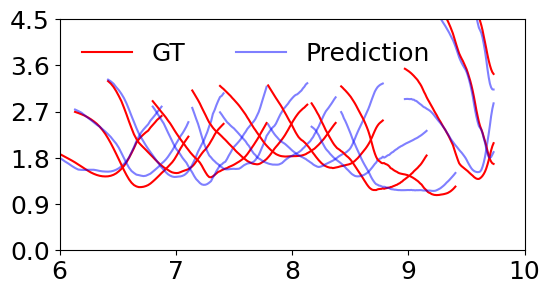

In [12]:
freqmap = read_freqmap('E:/dingjie/mipresearch/data/cochlear/sgfreqmapping.bin')

exp_root = 'E:/dingjie/mipresearch/reg_cochlear_monai/s8/exp_best_model'
exp = 'Exp_task16-kcl-chamfer-reg4p0-post_1'


case = 'PID_1689_PLANID_1096_LEFT'
case2 = 'PID_2674_PLANID_1312_LEFT'
case3 = 'PID_2182_PLANID_878_RIGHT'
case4 = 'PID_2552_PLANID_732_LEFT'

case = case3
# case = 'PID_3548_PLANID_4361_LEFT'

infor_name = case.replace('_LEFT', '').replace('_RIGHT', '')
infor = pycip.utils.loadmat(f'E:/dingjie/mipresearch/data/cochlear/prepos_mesh_all_DONOTDELETE_new/{infor_name}.mat')['cdb_infor']

md_tri = infor['pre_MD']['triangles'].T

gt_md = np.load(f'E:/dingjie/mipresearch/data/cochlear/data_128_inAtlas_99clip/test93/PrePost_FullMD_vtx/{case}.pkl', allow_pickle=True)
contacts = np.load(f'E:/dingjie/mipresearch/data/cochlear/data_128_inAtlas_99clip/test93/PrePost_contacts/{case}.pkl', allow_pickle=True)
# pred_md = np.load(f'{exp_root}/{exp}/evaluation/predicted_vtx/{case}.pkl', allow_pickle=True)[: 17947]
pred_md, _ = pycip.utils.read_mesh(f'E:/dingjie/mipresearch/reg_cochlear_monai/journal/TBME2024/revision2/output/mesh/nnunet/MD_upsample1/{case}.mesh')

electrode_config = json.load(open(f'E:/dingjie/mipresearch/data/cochlear/data_128_inAtlas_99clip/test93/electrode_config/{case}.json'))
electrode_config['electrodepos'] = contacts

bins = np.array(electrode_config['curvefreqs'])

dvfs_gt, dvfs_gt_smooth, vally_gt= get_dvf(electrode_config, gt_md, freqmap, bins)
dvfs_pred, dvfs_pred_smooth, vally_pred = get_dvf(electrode_config, pred_md, freqmap, bins)

fontsize = 18

chart = C.Chart()
chart.legend_fontsize = fontsize
chart.legend_loc = 'upper left'
chart.legend_ncol = 2
chart.config(fontsize, fontsize)
chart.set_figsize(6, 3).xticks(6, 10, 5).yticks(0, 4.5, 6)
for i in range(len(contacts)):

    if electrode_config['electrodestsv'][i] == 0:
        continue

    contact_angle = electrode_config['electrodeangs'][i]
    contact_freq = freqmap['freq'][np.argmin(np.abs(freqmap['ang'] - contact_angle))]
    t = 400
    t_log = 0.5
    x = np.log(bins[: -1])
    contact_freq_log = np.log(contact_freq)
    cut_ind = np.where((x > contact_freq_log - t_log) & (x < contact_freq_log + t_log))[0]
    chart.line(x[cut_ind], dvfs_gt_smooth[i][cut_ind], color='red', opacity=1, label='GT' if i  == 0 else None)
    chart.line(x[cut_ind], dvfs_pred_smooth[i][cut_ind], color='blue', opacity=0.5, label='Prediction' if i  == 0 else None)
    # chart.ax.text(x[vally_gt[i][0]], min(vally_gt[i][2], vally_pred[i][2]) - 0.6, str(i + 1), fontdict={'size': fontsize})

chart.show_legend(frameon=False)

203.566162109375 214.06906127929688
203.566162109375 214.06906127929688


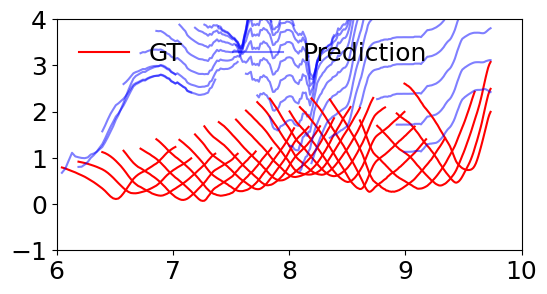

In [ ]:
freqmap = read_freqmap('E:/dingjie/mipresearch/data/cochlear/sgfreqmapping.bin')

exp_root = 'E:/dingjie/mipresearch/reg_cochlear_monai/s8/exp_best_model'
exp = 'Exp_task16-kcl-chamfer-reg4p0-post_1'


case = 'PID_1689_PLANID_1096_LEFT'
case2 = 'PID_2674_PLANID_1312_LEFT'
case3 = 'PID_2182_PLANID_878_RIGHT'
case4 = 'PID_2552_PLANID_732_LEFT'

case = case4
# case = 'PID_3548_PLANID_4361_LEFT'

infor_name = case.replace('_LEFT', '').replace('_RIGHT', '')
infor = pycip.utils.loadmat(f'E:/dingjie/mipresearch/data/cochlear/prepos_mesh_all_DONOTDELETE_new/{infor_name}.mat')['cdb_infor']

md_tri = infor['pre_MD']['triangles'].T

gt_md = np.load(f'E:/dingjie/mipresearch/data/cochlear/data_128_inAtlas_99clip/test93/PrePost_FullMD_vtx/{case}.pkl', allow_pickle=True)
contacts = np.load(f'E:/dingjie/mipresearch/data/cochlear/data_128_inAtlas_99clip/test93/PrePost_contacts/{case}.pkl', allow_pickle=True)
# pred_md = np.load(f'{exp_root}/{exp}/evaluation/predicted_vtx/{case}.pkl', allow_pickle=True)[: 17947]
pred_md, _ = pycip.utils.read_mesh(f'E:/dingjie/mipresearch/reg_cochlear_monai/journal/TBME2024/revision2/output/mesh/nnunet/MD_upsample1/{case}.mesh')

electrode_config = json.load(open(f'E:/dingjie/mipresearch/data/cochlear/data_128_inAtlas_99clip/test93/electrode_config/{case}.json'))
electrode_config['electrodepos'] = contacts

bins = np.array(electrode_config['curvefreqs'])

dvfs_gt, dvfs_gt_smooth, vally_gt= get_dvf(electrode_config, gt_md, freqmap, bins)
dvfs_pred, dvfs_pred_smooth, vally_pred = get_dvf(electrode_config, pred_md, freqmap, bins)

fontsize = 18

chart = C.Chart()
chart.legend_fontsize = fontsize
chart.legend_loc = 'upper left'
chart.legend_ncol = 2
chart.config(fontsize, fontsize)
chart.set_figsize(6, 3).xticks(6, 10, 5).yticks(-1, 4, 6)
for i in range(len(contacts)):

    if electrode_config['electrodestsv'][i] == 0:
        continue

    contact_angle = electrode_config['electrodeangs'][i]
    contact_freq = freqmap['freq'][np.argmin(np.abs(freqmap['ang'] - contact_angle))]
    t = 400
    t_log = 0.5
    x = np.log(bins[: -1])
    contact_freq_log = np.log(contact_freq)
    cut_ind = np.where((x > contact_freq_log - t_log) & (x < contact_freq_log + t_log))[0]
    chart.line(x[cut_ind], dvfs_gt_smooth[i][cut_ind], color='red', opacity=1, label='GT' if i  == 0 else None)
    chart.line(x[cut_ind], dvfs_pred_smooth[i][cut_ind], color='blue', opacity=0.5, label='Prediction' if i  == 0 else None)
    # chart.ax.text(x[vally_gt[i][0]], min(vally_gt[i][2], vally_pred[i][2]) - 0.6, str(i + 1), fontdict={'size': fontsize})

chart.show_legend(frameon=False)

## segnet

77.10202026367188 78.5793228149414
77.10202026367188 78.5793228149414


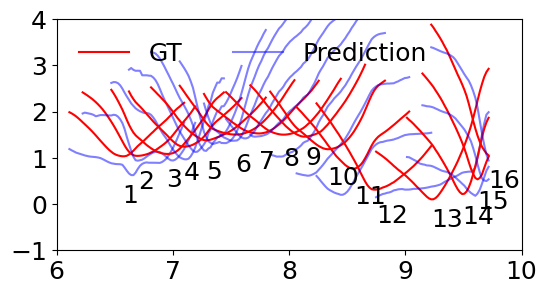

In [ ]:
freqmap = read_freqmap('E:/dingjie/mipresearch/data/cochlear/sgfreqmapping.bin')

exp_root = 'E:/dingjie/mipresearch/reg_cochlear_monai/s8/exp_best_model'
exp = 'Exp_task16-kcl-chamfer-reg4p0-post_1'

case = 'PID_1689_PLANID_1096_LEFT'
case2 = 'PID_3289_PLANID_3664_RIGHT'
case3 = 'PID_2674_PLANID_932_RIGHT'
case4 = 'PID_3548_PLANID_4361_LEFT'

case = case2
# case = 'PID_3548_PLANID_4361_LEFT'

infor_name = case.replace('_LEFT', '').replace('_RIGHT', '')
infor = pycip.utils.loadmat(f'E:/dingjie/mipresearch/data/cochlear/prepos_mesh_all_DONOTDELETE_new/{infor_name}.mat')['cdb_infor']

md_tri = infor['pre_MD']['triangles'].T

gt_md = np.load(f'E:/dingjie/mipresearch/data/cochlear/data_128_inAtlas_99clip/test93/PrePost_FullMD_vtx/{case}.pkl', allow_pickle=True)
contacts = np.load(f'E:/dingjie/mipresearch/data/cochlear/data_128_inAtlas_99clip/test93/PrePost_contacts/{case}.pkl', allow_pickle=True)
# pred_md = np.load(f'{exp_root}/{exp}/evaluation/predicted_vtx/{case}.pkl', allow_pickle=True)[: 17947]
pred_md, _ = pycip.utils.read_mesh(f'E:/dingjie/mipresearch/reg_cochlear_monai/journal/TBME2024/revision2/output/mesh/segnet/MD/{case}.mesh')

electrode_config = json.load(open(f'E:/dingjie/mipresearch/data/cochlear/data_128_inAtlas_99clip/test93/electrode_config/{case}.json'))
electrode_config['electrodepos'] = contacts

bins = np.array(electrode_config['curvefreqs'])

dvfs_gt, dvfs_gt_smooth, vally_gt= get_dvf(electrode_config, gt_md, freqmap, bins)
dvfs_pred, dvfs_pred_smooth, vally_pred = get_dvf(electrode_config, pred_md, freqmap, bins)

fontsize = 18

chart = C.Chart()
chart.legend_fontsize = fontsize
chart.legend_loc = 'upper left'
chart.legend_ncol = 2
chart.config(fontsize, fontsize)
chart.set_figsize(6, 3).xticks(6, 10, 5).yticks(-1, 4, 6)
for i in range(len(contacts)):

    if electrode_config['electrodestsv'][i] == 0:
        continue

    contact_angle = electrode_config['electrodeangs'][i]
    contact_freq = freqmap['freq'][np.argmin(np.abs(freqmap['ang'] - contact_angle))]
    t = 400
    t_log = 0.5
    x = np.log(bins[: -1])
    contact_freq_log = np.log(contact_freq)
    cut_ind = np.where((x > contact_freq_log - t_log) & (x < contact_freq_log + t_log))[0]
    chart.line(x[cut_ind], dvfs_gt_smooth[i][cut_ind], color='red', opacity=1, label='GT' if i  == 0 else None)
    chart.line(x[cut_ind], dvfs_pred_smooth[i][cut_ind], color='blue', opacity=0.5, label='Prediction' if i  == 0 else None)
    chart.ax.text(x[vally_gt[i][0]], min(vally_gt[i][2], vally_pred[i][2]) - 0.6, str(i + 1), fontdict={'size': fontsize})

chart.show_legend(frameon=False)

In [ ]:
dvf_error_p2p = pd.read_csv(f'{exp_root}/Exp_task06-kcl-p2p-reg4p0-post_1/evaluation/dvf_error.csv')
dvf_error_chamfer = pd.read_csv(f'{exp_root}/Exp_task16-kcl-chamfer-reg4p0-post_1/evaluation/dvf_error.csv')
dvf_error_cgan = pd.read_csv(f'E:/dingjie/mipresearch/data/cochlear/data_128_inAtlas_99clip/cgan_dvf_error.csv')
dvf_error_aba = pd.read_csv(f'E:/dingjie/mipresearch/data/cochlear/data_128_inAtlas_99clip/aba_dvf_error.csv')
dvf_error_nnunet = pd.read_csv(f'E:/dingjie/mipresearch/data/cochlear/data_128_inAtlas_99clip/nnunet_dvf_error.csv')
dvf_error_segnet = pd.read_csv(f'E:/dingjie/mipresearch/data/cochlear/data_128_inAtlas_99clip/segnet_dvf_error.csv')

electrode_type_info = pd.read_csv('E:/dingjie/mipresearch/data/cochlear/display_v4.csv')

cases = dvf_error_p2p.case.tolist()
types = []
num_contacts = []
for case in cases:
    t = case.split('_')
    plan, side = t[3], t[4]
    row = electrode_type_info[(electrode_type_info.PLAN_ID == int(plan)) & (electrode_type_info.SIDE == side)]
    if row.shape[0] == 0:
        print(case)
        continue
    types.append(row['ELECT_TYPE'].tolist()[0])
    num_contacts.append(row['ELECT_NUM'].tolist()[0])

brand = ['Advanced Bionics' if x.find('Bionics') != -1 else 'Cochlear' if x.find('Cochlear') != -1 else 'MedEl' for x in types]

dvf_error_p2p['type'] = types
dvf_error_chamfer['type'] = types
dvf_error_cgan['type'] = types
dvf_error_aba['type'] = types
dvf_error_nnunet['type'] = types
dvf_error_segnet['type'] = types

dvf_error_p2p['brand'] = brand
dvf_error_chamfer['brand'] = brand
dvf_error_cgan['brand'] = brand
dvf_error_aba['brand'] = brand
dvf_error_nnunet['brand'] = brand
dvf_error_segnet['brand'] = brand

dvf_error_p2p['num_contacts'] = num_contacts
dvf_error_chamfer['num_contacts'] = num_contacts
dvf_error_cgan['num_contacts'] = num_contacts
dvf_error_aba['num_contacts'] = num_contacts
dvf_error_nnunet['num_contacts'] = num_contacts
dvf_error_segnet['num_contacts'] = num_contacts

header = [['Method', 'Brand', 'Raw Freq. Shift (Hz)', 'Log Freq. Shift Perc. (%)', 'Distance Shift (mm)']]

table_data = []
for method, res in zip(['cGAN+ASM', 'p2p', 'chamfer', 'aba', 'nnunet', 'segnet'], 
                       [dvf_error_cgan, dvf_error_p2p, dvf_error_chamfer, dvf_error_aba, dvf_error_nnunet, dvf_error_segnet]):
    for brand in ['Advanced Bionics', 'Cochlear', 'MedEl']:
        row = [method, brand]
        for k in ['freq_shift', 'freq_index_shift', 'dist_shift']:
            cur_res = res[res.brand == brand][k].round(2)
            if k == 'freq_index_shift':
                cur_res = cur_res * 100 / 300
            if k == 'freq_shift':
                row.append('%.0f±%.0f' % (np.mean(cur_res), np.std(cur_res)))
            else:
                row.append('%.2f±%.2f' % (np.mean(cur_res), np.std(cur_res)))
        table_data.append(row)

pd.DataFrame(table_data, columns=header[0]).to_csv('dvf_error_withaba_nnunet.csv', index=False)
# C.Chart().table(table_data, header)

In [11]:
exp_root = 'E:/dingjie/mipresearch/reg_cochlear_monai/s8/exp_best_model'

dvf_error_p2p = pd.read_csv(f'{exp_root}/Exp_task06-kcl-p2p-reg4p0-post_1/evaluation/dvf_error.csv')
dvf_error_chamfer = pd.read_csv(f'{exp_root}/Exp_task16-kcl-chamfer-reg4p0-post_1/evaluation/dvf_error.csv')
dvf_error_cgan = pd.read_csv(f'E:/dingjie/mipresearch/data/cochlear/data_128_inAtlas_99clip/cgan_dvf_error.csv')
dvf_error_aba = pd.read_csv(f'E:/dingjie/mipresearch/data/cochlear/data_128_inAtlas_99clip/aba_dvf_error.csv')
dvf_error_elastix = pd.read_csv(f'E:/dingjie/mipresearch/data/cochlear/data_128_inAtlas_99clip/elastix_dvf_error.csv')
dvf_error_nnunet = pd.read_csv(f'E:/dingjie/mipresearch/data/cochlear/data_128_inAtlas_99clip/nnunet_dvf_error_upsample1.csv')
dvf_error_segnet = pd.read_csv(f'E:/dingjie/mipresearch/data/cochlear/data_128_inAtlas_99clip/segnet_dvf_error_upsample1.csv')

electrode_type_info = pd.read_csv('E:/dingjie/mipresearch/data/cochlear/display_v4.csv')

cases = dvf_error_p2p.case.tolist()
types = []
num_contacts = []
for case in cases:
    t = case.split('_')
    plan, side = t[3], t[4]
    row = electrode_type_info[(electrode_type_info.PLAN_ID == int(plan)) & (electrode_type_info.SIDE == side)]
    if row.shape[0] == 0:
        print(case)
        continue
    types.append(row['ELECT_TYPE'].tolist()[0])
    num_contacts.append(row['ELECT_NUM'].tolist()[0])

brand = ['Advanced Bionics' if x.find('Bionics') != -1 else 'Cochlear' if x.find('Cochlear') != -1 else 'MedEl' for x in types]

dvf_error_p2p['type'] = types
dvf_error_chamfer['type'] = types
dvf_error_cgan['type'] = types
dvf_error_aba['type'] = types
dvf_error_elastix['type'] = types
dvf_error_nnunet['type'] = types
dvf_error_segnet['type'] = types

dvf_error_p2p['brand'] = brand
dvf_error_chamfer['brand'] = brand
dvf_error_cgan['brand'] = brand
dvf_error_aba['brand'] = brand
dvf_error_elastix['brand'] = brand
dvf_error_nnunet['brand'] = brand
dvf_error_segnet['brand'] = brand

dvf_error_p2p['num_contacts'] = num_contacts
dvf_error_chamfer['num_contacts'] = num_contacts
dvf_error_cgan['num_contacts'] = num_contacts
dvf_error_aba['num_contacts'] = num_contacts
dvf_error_elastix['num_contacts'] = num_contacts
dvf_error_nnunet['num_contacts'] = num_contacts
dvf_error_segnet['num_contacts'] = num_contacts

header = [['Method', 'Brand', 'Raw Freq. Shift (Hz)', 'Log Freq. Shift Perc. (%)', 'Distance Shift (mm)']]

mean_data = []
table_data = []
for method, res in zip(['chamfer', 'p2p', 'cGAN+ASM', 'nnunet', 'segnet', 'aba', 'elastix'], 
                       [dvf_error_chamfer, dvf_error_p2p, dvf_error_cgan, dvf_error_nnunet, dvf_error_segnet, dvf_error_aba, dvf_error_elastix]):
    for brand in ['Advanced Bionics', 'Cochlear', 'MedEl']:
        row = [method, brand]
        for k in ['freq_shift', 'freq_index_shift', 'dist_shift']:
            cur_res = res[res.brand == brand][k].round(2)
            if k == 'freq_index_shift':
                cur_res = cur_res * 100 / 300
            mean_data.append(np.mean(cur_res))
            if k == 'freq_shift':
                row.append('%.0f±%.0f' % (np.mean(cur_res), np.std(cur_res)))
            else:
                row.append('%.2f±%.2f' % (np.mean(cur_res), np.std(cur_res)))
        table_data.append(row)

# pd.DataFrame(table_data, columns=header[0]).to_csv('dvf_error_withaba_nnunet_md_upsample1.csv', index=False)
# C.Chart().table(table_data, header)

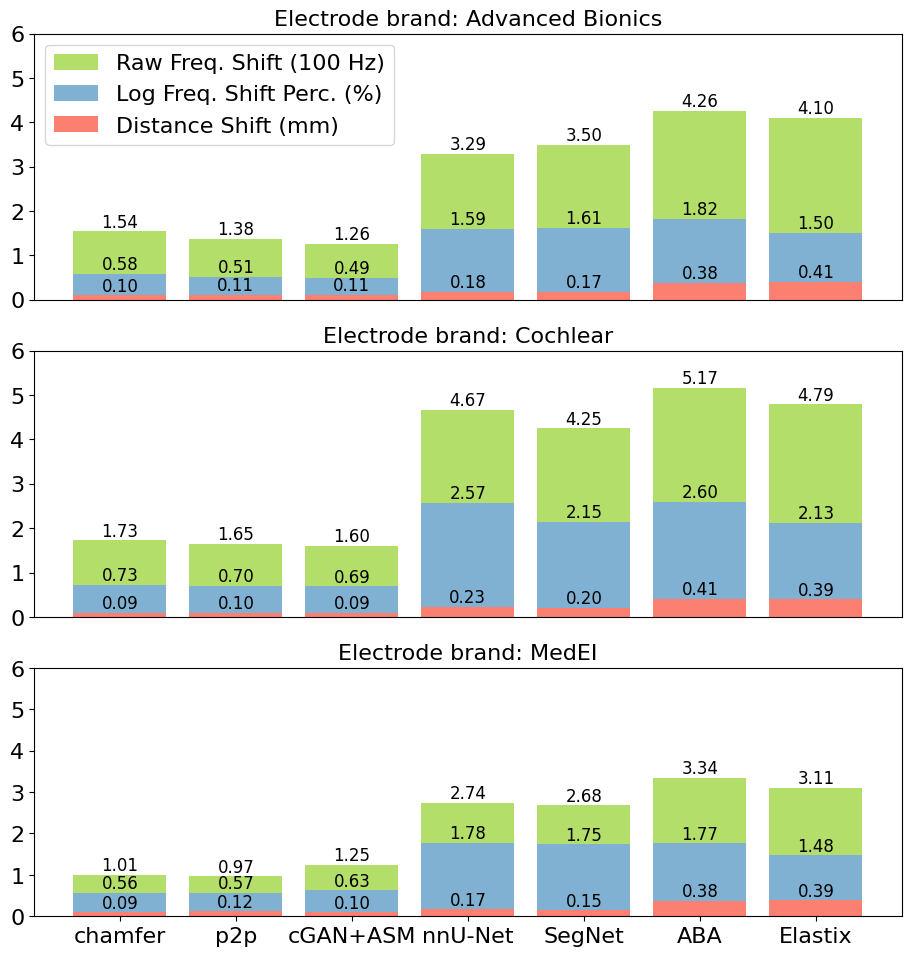

In [12]:
brand_mean_data = np.array(mean_data).reshape(-1, 3)
bar1 = brand_mean_data[0::3, 0] / 100
bar2 = brand_mean_data[0::3, 1]
bar3 = brand_mean_data[0::3, 2]
methods = ['chamfer', 'p2p', 'cGAN+ASM', 'nnU-Net', 'SegNet', 'ABA', 'Elastix']

C.ChartGroup.chart_cls.legend_fontsize = 16
C.ChartGroup.chart_cls.xticks_fontszie = 16
C.ChartGroup.chart_cls.yticks_fontszie = 16
C.ChartGroup.chart_cls.innertext_fontsize = 12
C.ChartGroup.chart_cls.title_fontsize = 16
cg = C.ChartGroup(3, 1, each_height=3.5, each_width=10)

chart = cg.get_chart(1, 1)
chart.bar(methods, brand_mean_data[0::3, 0] / 100, color=chart.color_scheme1[2], label='Raw Freq. Shift (100 Hz)', show_values=True, value_y_offset=0.1)
chart.bar(methods, brand_mean_data[0::3, 1], color=chart.color_scheme1[1], label='Log Freq. Shift Perc. (%)', show_values=True, value_y_offset=0.1)
chart.bar(methods, brand_mean_data[0::3, 2], color=chart.color_scheme1[0], label='Distance Shift (mm)', show_values=True, value_y_offset=0.1)
chart.yticks(0, 6, 7)
chart.legend_loc = 'upper left'
chart.show_legend()
chart.xaxis_off()
chart.title('Electrode brand: Advanced Bionics')

chart = cg.get_chart(2, 1)
chart.bar(methods, brand_mean_data[1::3, 0] / 100, color=chart.color_scheme1[2], label='Raw Freq. Shift (100 Hz)', show_values=True, value_y_offset=0.1)
chart.bar(methods, brand_mean_data[1::3, 1], color=chart.color_scheme1[1], label='Log Freq. Shift Perc. (%)', show_values=True, value_y_offset=0.1)
chart.bar(methods, brand_mean_data[1::3, 2], color=chart.color_scheme1[0], label='Distance Shift (mm)', show_values=True, value_y_offset=0.1)
chart.yticks(0, 6, 7)
chart.xaxis_off()
chart.title('Electrode brand: Cochlear')

chart = cg.get_chart(3, 1)
chart.bar(methods, brand_mean_data[2::3, 0] / 100, color=chart.color_scheme1[2], label='Raw Freq. Shift (100 Hz)', show_values=True, value_y_offset=0.1)
chart.bar(methods, brand_mean_data[2::3, 1], color=chart.color_scheme1[1], label='Log Freq. Shift Perc. (%)', show_values=True, value_y_offset=0.1)
chart.bar(methods, brand_mean_data[2::3, 2], color=chart.color_scheme1[0], label='Distance Shift (mm)', show_values=True, value_y_offset=0.1)
chart.yticks(0, 6, 7)
chart.title('Electrode brand: MedEI')

In [21]:
bar2

array([0.57962963, 0.50938272, 0.4908642 , 1.59407407, 1.61407407,
       1.82012346])